In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
from pathlib import Path
import graspologic as gl
from celegans_connectome_analysis.get_nx import get_adult_c_elegans_nx, get_fxnl_nx
import numpy as np

In [2]:
G = nx.read_gpickle('data/pruned_graph.gpickle')

In [3]:
muscle_nodes = [n for n in G.nodes if G.nodes[n]["neuron type"] == "Muscle"]

G.remove_nodes_from(muscle_nodes)
category_order = {'Sens.': 0, 'Inter.': 1, 'Mot.': 2, 'Mod.': 3, 'Other': 4}

ordered_nodes = sorted(G.nodes(), key=lambda n: category_order[G.nodes[n]["neuron type"]])

In [13]:
# get nodes that have 0 structural predecessors
no_pred_neurons = []
predecessors = {node: list(G.predecessors(node)) for node in G.nodes()}
for node, preds in predecessors.items():
    num_struc_preds = [p for p in preds if G[p][node]['stx_weight'] > 0]
    if len(num_struc_preds) == 0:
        no_pred_neurons.append(node)
        print(node, G.nodes[node]["neuron type"])
    if len(num_struc_preds) == 1:
        print("One connection:", node, G.nodes[node]["neuron type"], num_struc_preds[0])

ASJR Sens.
One connection: FLPR Sens. FLPL
One connection: IL2DL Sens. OLQDL
IL2DR Sens.
One connection: URAVR Mot. CEPVR
IL2VL Sens.
One connection: AVL Mod. AVKL


In [14]:
# nodes that have 0 functional predecessors
no_pred_neurons_fx = []
for node, preds in predecessors.items():
    num_fx_preds = [p for p in preds if G[p][node]['fx_weight'] > 0]
    if len(num_fx_preds) == 0:
        no_pred_neurons_fx.append(node)
        print(node, G.nodes[node]["neuron type"])
    if len(num_fx_preds) == 1:
        print("One connection:", node, G.nodes[node]["neuron type"], num_fx_preds[0])
# no neurons that have 0 functional predecessors

One connection: URAVR Mot. IL1VR


In [5]:
def get_successor_weight_counts(neuron):
    neighbors = list(G.successors(neuron))
    stx_neighbors = [n for n in neighbors if G[neuron][n]['stx_weight'] > 0]
    fx_neighbors = [n for n in neighbors if G[neuron][n]['fx_weight'] > 0]
    return stx_neighbors, fx_neighbors

for neuron in no_pred_neurons:
    print(neuron)
    stx_n, fx_n = get_successor_weight_counts(neuron)
    print(stx_n, fx_n)

ASJR
['ASKR', 'AINR', 'ALA'] ['AWCR', 'IL1R', 'OLLR', 'AIML', 'AIMR', 'AINL', 'RIAL', 'RIGR', 'RIML', 'RIMR', 'SMDVL']
IL2DR
['ASIR', 'AWCR', 'OLQDR', 'RIH', 'IL1DR', 'RMED', 'RMEL', 'RMER', 'RMEV', 'URADR'] ['ADEL', 'BAGL', 'OLQDL', 'ALA', 'SAAVL']
IL2VL
['OLQVL', 'AIBR', 'RIAL', 'RIBL', 'RIPL', 'IL1VL', 'RMED', 'RMEL', 'RMER', 'RMEV', 'URAVL'] ['AUAR', 'IL1VR', 'IL2R']


In [6]:
from collections import deque

def bfs_neighbors(G, root, max_neighbors):
    visited = set([root])
    queue = deque([root])
    chosen = []

    while queue and len(chosen) < max_neighbors:
        current = queue.popleft()
        for nbr in G.successors(current):
            if nbr not in visited and G[current][nbr].get('stx_weight', 0) > 0:
                visited.add(nbr)
                chosen.append(nbr)
                queue.append(nbr)
                if len(chosen) == max_neighbors:
                    break
    return chosen

def visualize_subgraph(G, root, max_neighbors=11):
    """
    Visualize a subgraph of DiGraph G around 'root',
    including up to max_neighbors neighbors, 
    and only edges where G[u][v]['stx_weight'] > 0.
    """

    # --- Option A: Pick neighbors by largest 'stx_weight' from root ---
    # Filter only outgoing edges from root that have stx_weight > 0
    out_edges = [
        (root, nbr) for nbr in G.successors(root)
        if 'stx_weight' in G[root][nbr] and G[root][nbr]['stx_weight'] > 0
    ]
    # Sort neighbors by descending weight
    out_edges_sorted = sorted(
        out_edges,
        key=lambda e: G[e[0]][e[1]]['stx_weight'],
        reverse=True
    )
    # Take up to max_neighbors of the highest-weight neighbors
    chosen_neighbors = bfs_neighbors(G, root=root, max_neighbors=max_neighbors)

    # Combine root + chosen neighbors
    sub_nodes = [root] + chosen_neighbors

    # Now collect all edges among these nodes (directed) where stx_weight > 0
    subgraph_edges = []
    for u in sub_nodes:
        for v in sub_nodes:
            if u != v and G.has_edge(u, v):
                if 'stx_weight' in G[u][v] and G[u][v]['stx_weight'] > 0:
                    subgraph_edges.append((u, v))

    # Build a fresh DiGraph with these edges
    H = nx.DiGraph()
    H.add_nodes_from(sub_nodes)
    for (u, v) in subgraph_edges:
        H.add_edge(u, v, stx_weight=G[u][v]['stx_weight'])

    # Optionally set up a layout (spring_layout, circular_layout, etc.)
    pos = nx.spring_layout(H, seed = 10)

    # Draw the graph
    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(H, pos, node_size=800)
    nx.draw_networkx_labels(H, pos, font_size=10)
    nx.draw_networkx_edges(
        H, pos, 
        arrowstyle='->', arrowsize=15, 
        connectionstyle='arc3,rad=0.1'  # Helps visually with overlapping edges
    )

    # If you want to show weights as edge labels:
    edge_labels = nx.get_edge_attributes(H, 'stx_weight')
    nx.draw_networkx_edge_labels(H, pos, edge_labels=edge_labels, font_color='red')

    plt.title(f"Subgraph around '{root}' (up to {max_neighbors} neighbors)")
    plt.axis('off')
    plt.show()
    return H


['ASIR', 'AWCR', 'OLQDR', 'RIH', 'IL1DR', 'RMED', 'RMEL', 'RMER', 'RMEV', 'URADR'] ['ADEL', 'BAGL', 'OLQDL', 'ALA', 'SAAVL']


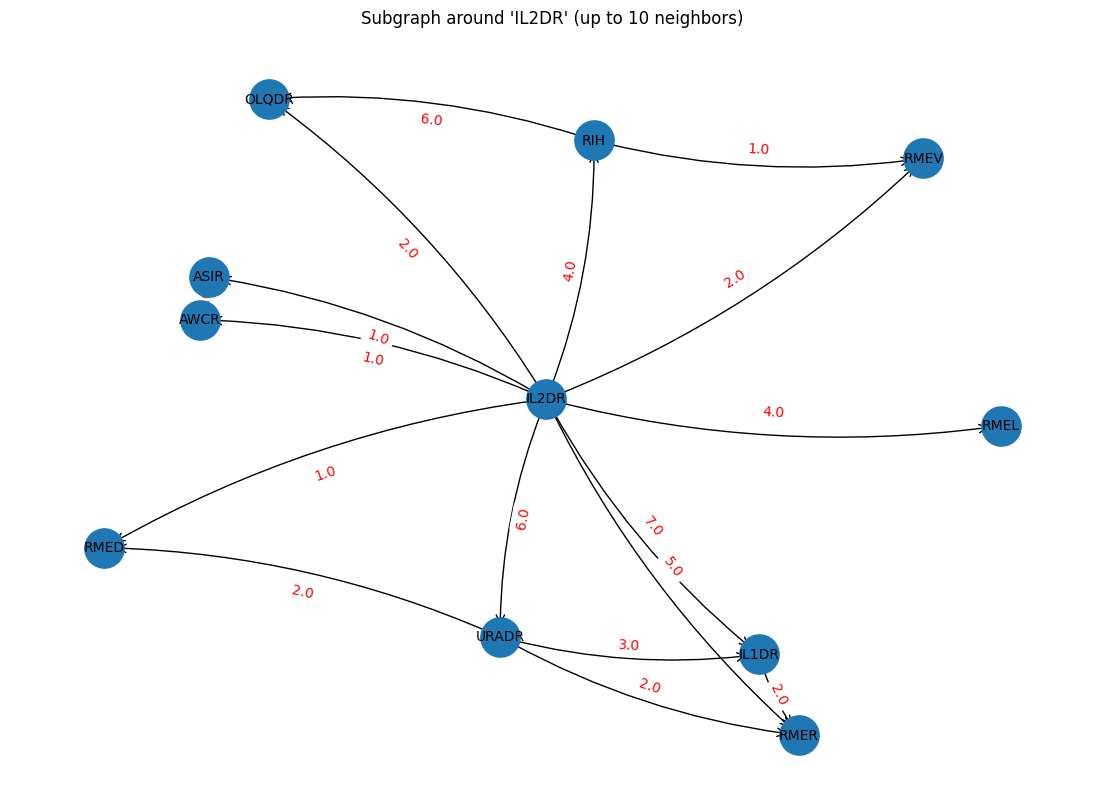

{'ADEL', 'SAAVL', 'OLQDL', 'BAGL', 'ALA'}
5


In [18]:
root_node = 'IL2DR'
stx_n, fx_n = get_successor_weight_counts(root_node)
print(stx_n, fx_n)
subgraph = visualize_subgraph(G, root_node, max_neighbors=10)
subgraph_nodes = subgraph.nodes()
print(set(fx_n) - set(subgraph_nodes))
print(len(set(fx_n) - set(subgraph_nodes)))

In [16]:
def get_subgraph_paths_among_targets(G, target_nodes):
    """
    Return a subgraph of the directed graph G that contains:
      1) All 'target_nodes',
      2) For each pair (u, v) in target_nodes (u != v),
         if there is a path from u to v, then all nodes
         on at least one such path.

    The returned subgraph preserves all edges from G among
    the nodes that end up in it. 
    """
    # Start with the target nodes themselves
    sub_nodes = set(target_nodes)

    # For each ordered pair of target nodes (u, v):
    for u in target_nodes:
        for v in target_nodes:
            if u == v:
                continue
            # Try to find a path (shortest path here) from u to v
            try:
                path_nodes = nx.shortest_path(G, source=u, target=v)
                # Add all path nodes to our sub_nodes
                sub_nodes.update(path_nodes)
            except nx.NetworkXNoPath:
                # If no path exists, do nothing
                print("Missing path:", u, v)
                pass

    # Induce a subgraph on the collected nodes
    # This automatically preserves the original structure among these nodes.
    subgraph = G.subgraph(sub_nodes).copy()
    return subgraph

Missing path: ADEL IL2DR
4


/home/gwyneth-local/celegans_connectome_analysis/celegans_connectome_analysis/get_nx.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["neuron type"] = df["neuron type"].fillna(method='ffill')


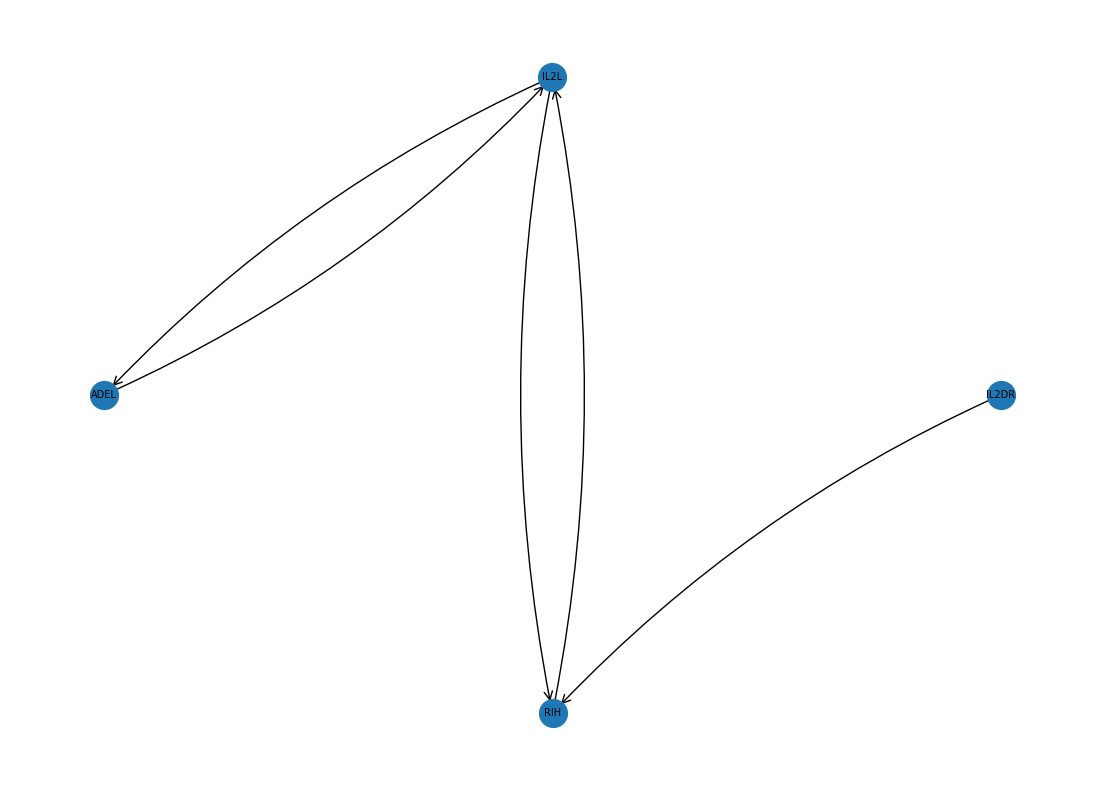

In [21]:
G_stx = get_adult_c_elegans_nx()
# func_graph = get_subgraph_paths_among_targets(G_stx, fx_n)
func_graph = get_subgraph_paths_among_targets(G_stx, [root_node, 'ADEL'])
print(len(func_graph.nodes()))
pos = nx.circular_layout(func_graph)

# Draw the graph
plt.figure(figsize=(14, 10))
nx.draw_networkx_nodes(func_graph, pos, node_size=400)
nx.draw_networkx_labels(func_graph, pos, font_size=7)
nx.draw_networkx_edges(
    func_graph, pos, 
    arrowstyle='->', arrowsize=15, 
    connectionstyle='arc3,rad=0.1'  # Helps visually with overlapping edges
)

plt.axis('off')
plt.show()